# GoDaddy - Microbusiness Density Forecasting
Forecast Next Month’s Microbusiness Density Using Sktime - Simple Solution

## Required Installations

In [ ]:
import sktime

In [ ]:
!pip install sktime[all_extras]

## Importing Relevant Libraries

In [ ]:
import numpy as np
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    ExpandingWindowSplitter)
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Collecting Data

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


df_train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
df_test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
df_census = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


## EDA

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25080 entries, 0 to 25079
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              25080 non-null  object
 1   cfips               25080 non-null  int64 
 2   first_day_of_month  25080 non-null  object
dtypes: int64(1), object(2)
memory usage: 587.9+ KB


## Feature Engineering

In [ ]:
df_train['first_day_of_month'] = pd.to_datetime(df_train['first_day_of_month'])
df_train.set_index('first_day_of_month', inplace = True)
df_train.index = df_train.index.to_period(freq='M')
df_train_ts = df_train[['microbusiness_density', 'cfips']]

unique_cifps = df_train.cfips.unique()

## Model Training

Processing cifps: 100%|██████████| 3135/3135 [00:29<00:00, 106.15it/s]


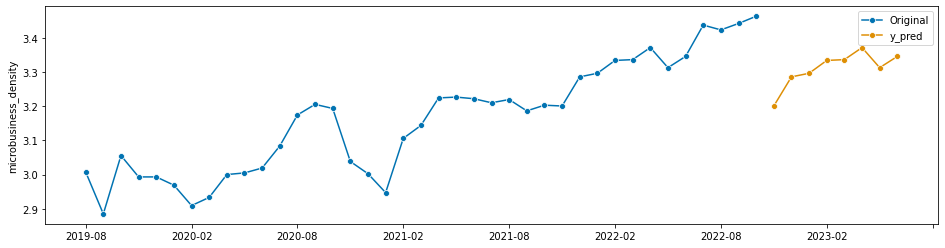

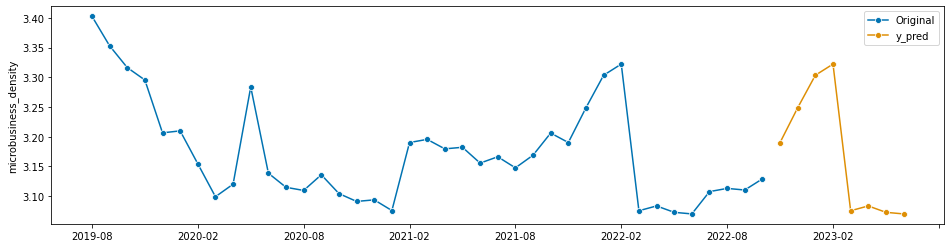

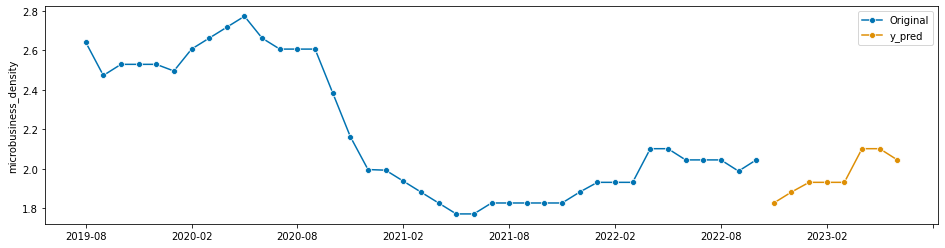

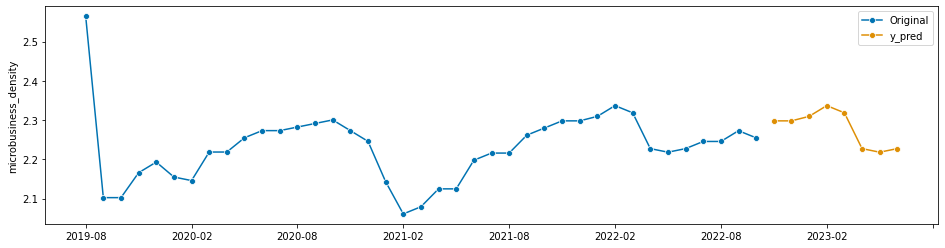

In [ ]:
# Loop over unique county-year pairs in unique_cifps
for itr, cifps in enumerate(tqdm(unique_cifps, desc = 'Processing cifps')):
    
    # Get microbusiness density values for current county-year pair
    df_sel = df_train_ts[df_train_ts['cfips'] == cifps]['microbusiness_density']
    

    #Gridsearch
    cv = ExpandingWindowSplitter(fh=fh)
    forecaster = NaiveForecaster()
    param_grid = {"strategy" : ["last", "mean", "drift"]}
    gscv = ForecastingGridSearchCV(
        forecaster=forecaster,
        param_grid=param_grid,
        cv=cv)
    gscv.fit(y)

    y_pred = gscv.predict(fh)
    # Initialize and fit a NaiveForecaster on the microbusiness density values
    forecaster = NaiveForecaster(strategy="last", sp=12)
    forecaster.fit(df_sel)
    
    # Predict microbusiness density for the next 8 months
    fh = np.arange(1, 9)
    y_pred = forecaster.predict(fh)
    
    # Plot original and predicted series every 1000 iterations
    if itr%1000 == 0:
        plot_series(df_sel, y_pred, labels=["Original", "y_pred"])
    
    # Update df_test with predicted values for current county-year pair
    df_test.loc[df_test['cfips'] == cifps, 'microbusiness_density'] = y_pred.values

# Create submission DataFrame with row_id and microbusiness_density columns from df_test
df_submission = pd.DataFrame(df_test[['row_id', 'microbusiness_density']])

# Save submission DataFrame to CSV file
df_submission.to_csv('submission_01.csv', index = False)


## The score achieved with this simple baseline model is **6.7819**.
**Todo:**

- Evaluation metrics 
- Hyper-parameter tuning
- Exploring other models
- Ensemble models 